## Imports

In [ ]:
!pip install geodatasets
!pip install contextily
!pip install geopandas
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.4 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import pytz
import xml.etree.ElementTree as ET
import ast
import gdown

from sklearn.cluster import DBSCAN # or do we want to use kclusters?
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import geopandas as gpd
import geodatasets
import contextily as cx

import requests

## Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/My Drive/Online_Behavior/project-2-locations/benny_Google_Maps_api_key.txt", "r") as f:
    api_key = f.read().strip()

In [ ]:
file_path = '/content/drive/My Drive/Online_Behavior/project-2-locations/benny-location-history.json'
df = pd.read_json(file_path, orient="records")

In [ ]:
file_id = "1hY7oBzcwP2VFMcJSg1Tcnfmxqo5_CsGu"
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id={file_id}" -O api_key.txt

with open("api_key.txt", "r") as f:
    api_key = f.read().strip()

--2025-04-01 19:00:49--  https://drive.google.com/uc?export=download&id=1hY7oBzcwP2VFMcJSg1Tcnfmxqo5_CsGu
Resolving drive.google.com (drive.google.com)... 74.125.26.113, 74.125.26.102, 74.125.26.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hY7oBzcwP2VFMcJSg1Tcnfmxqo5_CsGu&export=download [following]
--2025-04-01 19:00:49--  https://drive.usercontent.google.com/download?id=1hY7oBzcwP2VFMcJSg1Tcnfmxqo5_CsGu&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.215.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39 [application/octet-stream]
Saving to: ‘api_key.txt’

api_key.txt         100%[===================>]      39  --.-KB/s    in 0s      



In [ ]:
file_id = "12QU4_R_KdGqr8v0Y4e6yqNlTUtUI49KU" # Benny's data
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id={file_id}" -O location.json

with open("location.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

--2025-04-01 18:46:18--  https://drive.google.com/uc?export=download&id=12QU4_R_KdGqr8v0Y4e6yqNlTUtUI49KU
Resolving drive.google.com (drive.google.com)... 74.125.26.113, 74.125.26.138, 74.125.26.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12QU4_R_KdGqr8v0Y4e6yqNlTUtUI49KU&export=download [following]
--2025-04-01 18:46:18--  https://drive.usercontent.google.com/download?id=12QU4_R_KdGqr8v0Y4e6yqNlTUtUI49KU&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.215.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566944 (554K) [application/octet-stream]
Saving to: ‘location.json’

location.json       100%[===================>] 553.66K  --.-KB/s    

###Coordinates from Timeline

#### visit

In [ ]:
# df.iloc[100]  -->   endTime,	startTime, 	visit	{'hierarchyLevel': '0', 'topCandidate': {'prob...} },  activity, timelinePath

# df.iloc[100]["visit"]. -->. {'hierarchyLevel': '0', 'topCandidate': {'probability': '0.896274','semanticType': 'Unknown','placeID': 'ChIJZwdvyctLs4kR1ZRlh1lHxno', 'placeLocation': 'geo':37.875700,-79.309532'}, 'probability': '0.979885'}

# df.iloc[100]["visit"]["topCandidate"]. -->  {'probability': '0.896274', 'semanticType': 'Unknown', 'placeID': 'ChIJZwdvyctLs4kR1ZRlh1lHxno', 'placeLocation': 'geo:37.875700,-79.309532'}

# df.iloc[100]["visit"]["topCandidate"]["placeLocation"]. --> geo:37.875700,-79.309532

#### activity

In [ ]:
# df.iloc[500]["activity"] --> {'probability': '0.964542', 'end': 'geo:38.050155,-78.527237',
# 'topCandidate': {'type': 'in passenger vehicle', 'probability': '0.894587'}, 'distanceMeters': '7292.791504', 'start': 'geo:38.029628,-78.512489'}

# df.iloc[500]["activity"]["topCandidate"]["type"] --> in passenger vehicle

print(df.iloc[500]["activity"]["start"])
print(df.iloc[500]["activity"]["end"])

geo:38.029628,-78.512489
geo:38.050155,-78.527237


#### timelinePath

In [ ]:
# df.iloc[800]["timelinePath"]. -->. [{'point': 'geo:38.027379,-78.511121', 'durationMinutesOffsetFromStartTime': '79'}]

df.iloc[800]["timelinePath"][0]["point"]

'geo:38.027379,-78.511121'

### Preprocessing

In [ ]:
records = []
for entry in data:
  if 'visit' in entry and 'topCandidate' in entry['visit']:
    start_time = entry['startTime']
    end_time = entry['endTime']
    location_str = entry['visit']['topCandidate']['placeLocation']
    if location_str.startswith("geo:"):
      lat, lon = map(float, location_str[4:].split(","))
      records.append({
        'start_time': pd.to_datetime(start_time),
        'end_time': pd.to_datetime(end_time),
        'latitude': lat,
        'longitude': lon
      })
  if 'timelinePath' in entry:
    base_time = pd.to_datetime(entry['startTime'], errors='coerce') # for the first point
    for i in range(1, len(entry['timelinePath'])):

      prev_point = entry['timelinePath'][i - 1]
      curr_point = entry['timelinePath'][i]

      prev_offset = int(prev_point['durationMinutesOffsetFromStartTime'])
      curr_offset = int(curr_point['durationMinutesOffsetFromStartTime'])

      prev_time = base_time + pd.to_timedelta(prev_offset, unit='m')
      curr_time = base_time + pd.to_timedelta(curr_offset, unit='m')

      duration = (curr_time - prev_time).total_seconds()

      if duration > 600: # places stayed at for longer than 10 mins?
        location_str = curr_point['point']
        if location_str.startswith("geo:"):
          lat, lon = map(float, location_str[4:].split(","))
          records.append({
            'start_time': prev_time,
            'end_time': curr_time,
            'latitude': lat,
            'longitude': lon
          })
locations = pd.DataFrame(records)

locations['start_time'] = pd.to_datetime(locations['start_time'], utc=True)
locations['end_time'] = pd.to_datetime(locations['end_time'], utc=True)
locations['start_time'] = locations['start_time'].dt.tz_convert('US/Eastern')
locations['end_time'] = locations['end_time'].dt.tz_convert('US/Eastern')
# the above fixed an issue where the times would not convert and turn into NaT

locations['duration'] = (locations['end_time'] - locations['start_time']).dt.total_seconds()
locations

filtered_locations = locations[locations['duration'] > 600] # places stayed at for longer than 10 mins?
filtered_locations

,start_time,end_time,latitude,longitude,duration
0,2024-10-28 21:55:12.345000-04:00,2024-10-29 07:27:08.230000-04:00,38.033553,-78.507977,34315.885
1,2024-10-29 07:27:08.230000-04:00,2024-11-02 19:22:52.081000-04:00,38.027414,-78.511266,388543.851
2,2024-11-02 19:31:13-04:00,2024-11-02 21:13:04.038000-04:00,38.036071,-78.487989,6111.038
3,2024-11-02 21:16:46.048000-04:00,2024-11-03 12:09:33.053000-05:00,38.051446,-78.498845,57167.005
4,2024-11-03 12:09:33.053000-05:00,2024-11-07 10:53:01.482000-05:00,38.060587,-78.493320,341008.429
...,...,...,...,...,...
421,2025-03-23 14:29:00-04:00,2025-03-23 14:41:00-04:00,38.029126,-78.513869,720.000
422,2025-03-23 22:40:00-04:00,2025-03-23 23:33:00-04:00,38.055780,-78.521198,3180.000
423,2025-03-24 00:09:00-04:00,2025-03-24 00:45:00-04:00,38.027432,-78.510978,2160.000
424,2025-03-24 20:15:00-04:00,2025-03-24 22:00:00-04:00,38.052863,-78.510374,6300.000


## Clustering

In [ ]:
# DBSCAN Clustering (grouping locations that are close together)

epsilon = 0.001
min_samples = 5
coords = filtered_locations[['latitude', 'longitude']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
db = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(coords_scaled)
filtered_locations['cluster'] = db.labels_
filtered_locations

<ipython-input-6-c8909bfff5b7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_locations['cluster'] = db.labels_


,start_time,end_time,latitude,longitude,duration,cluster
0,2024-10-28 21:55:12.345000-04:00,2024-10-29 07:27:08.230000-04:00,38.033553,-78.507977,34315.885,0
1,2024-10-29 07:27:08.230000-04:00,2024-11-02 19:22:52.081000-04:00,38.027414,-78.511266,388543.851,0
2,2024-11-02 19:31:13-04:00,2024-11-02 21:13:04.038000-04:00,38.036071,-78.487989,6111.038,5
3,2024-11-02 21:16:46.048000-04:00,2024-11-03 12:09:33.053000-05:00,38.051446,-78.498845,57167.005,-1
4,2024-11-03 12:09:33.053000-05:00,2024-11-07 10:53:01.482000-05:00,38.060587,-78.493320,341008.429,-1
...,...,...,...,...,...,...
421,2025-03-23 14:29:00-04:00,2025-03-23 14:41:00-04:00,38.029126,-78.513869,720.000,0
422,2025-03-23 22:40:00-04:00,2025-03-23 23:33:00-04:00,38.055780,-78.521198,3180.000,-1
423,2025-03-24 00:09:00-04:00,2025-03-24 00:45:00-04:00,38.027432,-78.510978,2160.000,0
424,2025-03-24 20:15:00-04:00,2025-03-24 22:00:00-04:00,38.052863,-78.510374,6300.000,8


## Visualization

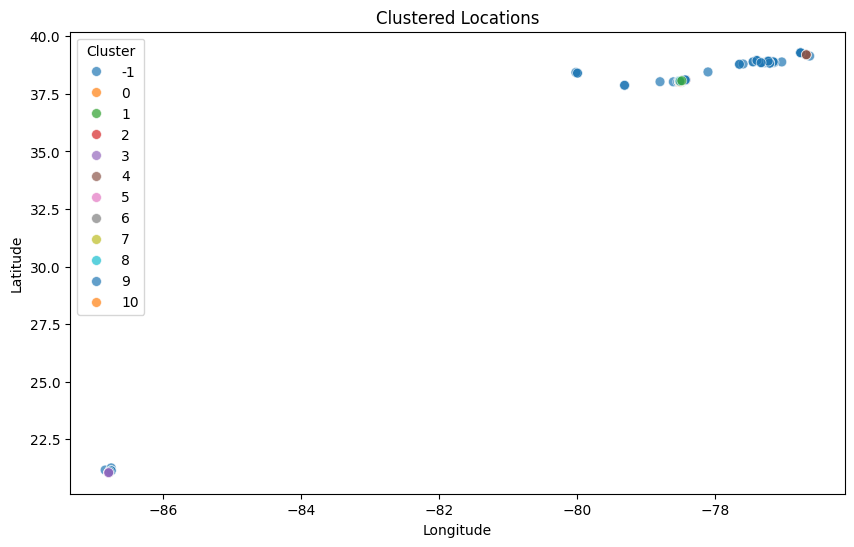

In [ ]:
# some graphing stuff
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_locations, x='longitude', y='latitude', hue='cluster', palette='tab10', s=50, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Locations')
plt.legend(title='Cluster')
plt.show()

<ipython-input-10-b03316567951>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


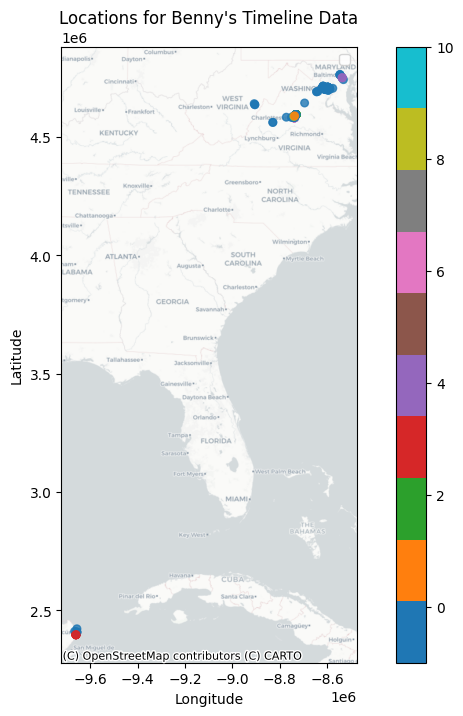

In [ ]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_locations, geometry=gpd.points_from_xy(filtered_locations.longitude, filtered_locations.latitude))

# Set coordinate system to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to web Mercator projection for plotting with contextily
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, column="cluster", cmap="tab10", legend=True, markersize=30, alpha=0.8) # plot by cluster

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Labels
ax.set_title("Locations for Benny's Timeline Data")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()

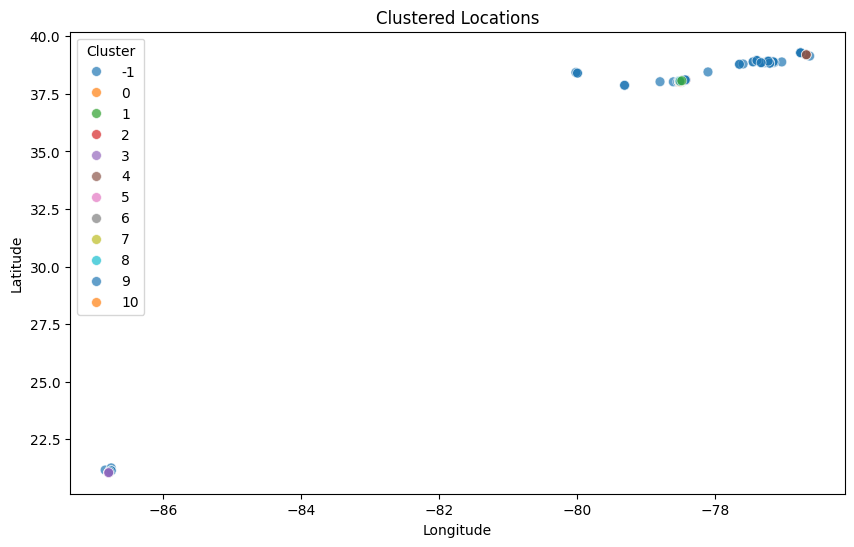

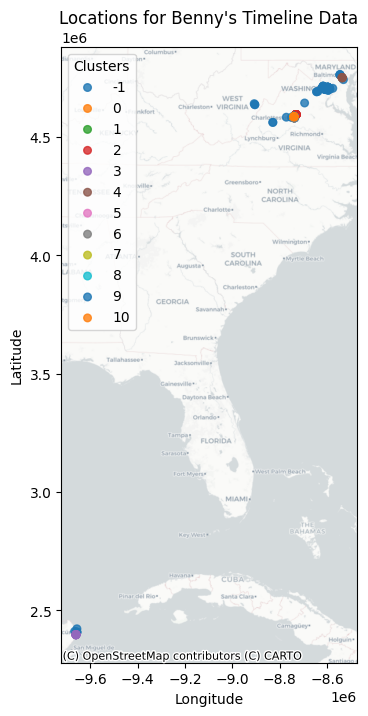

In [ ]:
# THIS CODE IS TO MAKE THE CLUSTER COLORS MATCH AND FIX THE WEIRD LEGEND ON THE MAP VERSION

# Define a consistent color mapping based on Seaborn's tab10 palette
unique_clusters = sorted(filtered_locations['cluster'].unique())
palette = sns.color_palette("tab10", len(unique_clusters))
color_mapping = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_locations,
    x='longitude',
    y='latitude',
    hue='cluster',
    palette=color_mapping,
    s=50, alpha=0.7
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Locations')
plt.legend(title='Cluster')
plt.show()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    filtered_locations, geometry=gpd.points_from_xy(filtered_locations.longitude, filtered_locations.latitude)
)

# Set coordinate system to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to web Mercator projection for contextily plotting
gdf = gdf.to_crs(epsg=3857)

# Plot with consistent colors !!!
fig, ax = plt.subplots(figsize=(10, 8))
for cluster, color in color_mapping.items():
    cluster_data = gdf[gdf["cluster"] == cluster]
    cluster_data.plot(ax=ax, color=[color] * len(cluster_data), markersize=30, alpha=0.8, label=f"{cluster}")

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Labels and legend
ax.set_title("Locations for Benny's Timeline Data")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Clusters")

plt.show()

## Google Maps API Feature Labeling

In [ ]:
url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
params = {
    'location': '37.875700,-79.309532',
    'radius': 50,  # Search within 50 meters
    'key': api_key
}

response = requests.get(url, params=params)
data = response.json()
#print(data)

if 'results' in data and len(data['results']) > 0:
  place = data['results'][0]  # Get the top result
  print(place)

{'business_status': 'OPERATIONAL', 'geometry': {'location': {'lat': 37.8757003, 'lng': -79.3095316}, 'viewport': {'northeast': {'lat': 37.8769539802915, 'lng': -79.30809766970849}, 'southwest': {'lat': 37.8742560197085, 'lng': -79.31079563029151}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png', 'icon_background_color': '#7B9EB0', 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/generic_pinlet', 'name': 'Fairfield Safety Rest Area', 'opening_hours': {'open_now': True}, 'photos': [{'height': 3060, 'html_attributions': ['<a href="https://maps.google.com/maps/contrib/104158207645061052975">John Seckar</a>'], 'photo_reference': 'AUy1YQ0tW56sa_x_c67GH4C9_I3PRdSMV-oUMVNa6_kF19hXASvi-_tqDJ-fYoexIP2eewjUAw-Nw075CCL6CqDfsD3nSLnADMK76MHOUOJAmTlyh_4CEe9tO2hILQ7gK8hJoCWuD9V2CysDNgpfndt4l97Vsebz-j7KMccOfVSPK47G7rZCC-H2gHCzAbohnl1TbVqlvk5bAp_gWrLiMRf7BzeBChWCK9o-rRnZManPObNuo1aN4hIDavE4HPl2UaeG5N01-rAEC-CMZ2zXdHKW0tJbO73Hoy80

In [ ]:
def get_place_details(latitude, longitude, api_key):
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {
        'location': f"{latitude},{longitude}",
        'radius': 50,  # Search radius in meters
        'key': api_key
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'results' in data and len(data['results']) > 0:
        place = data['results'][0]  # Get the top result
        return {
            "name": place.get("name"),
            "types": place.get("types"),
            "vicinity": place.get("vicinity")
        }
    else:
        return None

In [ ]:
# Dictionary to cache results and avoid duplicate API calls
location_cache = {}

# Apply function to each row
def enrich_with_place_info(row):
    lat, lon = row["latitude"], row["longitude"]
    location_key = (lat, lon)

    if location_key not in location_cache:
        #time.sleep(0.5)  # Prevent hitting API limits
        location_cache[location_key] = get_place_details(lat, lon, api_key)

    return pd.Series(location_cache[location_key])

# Apply function to add new columns
filtered_locations[["place_name", "place_types", "place_vicinity"]] = filtered_locations.apply(enrich_with_place_info, axis=1)

filtered_locations["place_types"] = filtered_locations["place_types"].astype(str)

# Display enriched DataFrame
print(filtered_locations)

print(filtered_locations["place_types"].unique())
print(filtered_locations["place_name"].unique())

                          start_time                         end_time  \
0   2024-10-28 21:55:12.345000-04:00 2024-10-29 07:27:08.230000-04:00   
1   2024-10-29 07:27:08.230000-04:00 2024-11-02 19:22:52.081000-04:00   
2          2024-11-02 19:31:13-04:00 2024-11-02 21:13:04.038000-04:00   
3   2024-11-02 21:16:46.048000-04:00 2024-11-03 12:09:33.053000-05:00   
4   2024-11-03 12:09:33.053000-05:00 2024-11-07 10:53:01.482000-05:00   
..                               ...                              ...   
421        2025-03-23 14:29:00-04:00        2025-03-23 14:41:00-04:00   
422        2025-03-23 22:40:00-04:00        2025-03-23 23:33:00-04:00   
423        2025-03-24 00:09:00-04:00        2025-03-24 00:45:00-04:00   
424        2025-03-24 20:15:00-04:00        2025-03-24 22:00:00-04:00   
425        2025-03-25 00:20:00-04:00        2025-03-25 00:33:00-04:00   

      latitude  longitude    duration  cluster              place_name  \
0    38.033553 -78.507977   34315.885        0   

<ipython-input-18-333717b7547b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_locations[["place_name", "place_types", "place_vicinity"]] = filtered_locations.apply(enrich_with_place_info, axis=1)
<ipython-input-18-333717b7547b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_locations[["place_name", "place_types", "place_vicinity"]] = filtered_locations.apply(enrich_with_place_info, axis=1)
<ipython-input-18-333717b7547b>:16: SettingWithCopyWarning: 
A value is trying to be set on a 

In [ ]:
# types of places:  ['route' 'locality' 'political' 'pharmacy' 'point_of_interest' 'store' 'health' 'establishment' 'neighborhood']

# Filter out rows where place_types is exactly "route"
filtered_locations = filtered_locations[filtered_locations["place_types"] != "['route']"]
# Reset index after filtering
filtered_locations.reset_index(drop=True, inplace=True)

print(filtered_locations["place_name"].unique())
print(filtered_locations)

['Charlottesville' 'Wegmans Pharmacy' 'Chantilly' 'Hunter Mill District'
 nan 'Cancún' 'Linthicum Heights' 'Rio' 'Fairfield Safety Rest Area'
 'University of Virginia' 'Rosemont' 'Tysons' 'Arlington' 'Annandale'
 'Glen Burnie' 'Gainesville' 'Hollymead' 'Seven Corners']
                         start_time                         end_time  \
0  2024-11-02 21:16:46.048000-04:00 2024-11-03 12:09:33.053000-05:00   
1  2024-11-12 13:09:04.706000-05:00 2024-11-14 16:34:10.590000-05:00   
2  2024-11-23 11:44:48.034000-05:00 2024-11-23 12:28:31.041000-05:00   
3  2024-11-23 16:29:39.558000-05:00 2024-11-23 16:39:57.033000-05:00   
4  2024-11-23 16:29:39.558000-05:00 2024-11-23 16:39:57.033000-05:00   
..                              ...                              ...   
95        2025-03-11 12:07:00-04:00        2025-03-11 13:37:00-04:00   
96        2025-03-12 16:37:00-04:00        2025-03-12 17:18:00-04:00   
97        2025-03-17 00:19:00-04:00        2025-03-17 00:55:00-04:00   
98        

<ipython-input-20-b0710b584fd4>:22: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax, color=color, markersize=30, label=place, alpha=0.8)


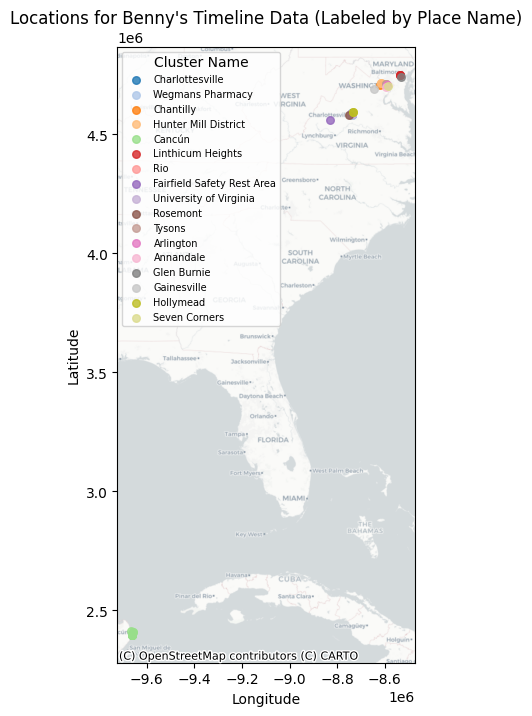

In [ ]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    filtered_locations,
    geometry=gpd.points_from_xy(filtered_locations.longitude, filtered_locations.latitude)
)

# Set coordinate system to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator projection for better plotting
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 8))

# Create a color map for unique place names
unique_places = gdf["place_name"].unique()
colors = plt.cm.tab20(range(len(unique_places)))  # Generate unique colors

# Plot each place separately
for place, color in zip(unique_places, colors):
    subset = gdf[gdf["place_name"] == place]
    subset.plot(ax=ax, color=color, markersize=30, label=place, alpha=0.8)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Labels and title
ax.set_title("Locations for Benny's Timeline Data (Labeled by Place Name)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add legend
ax.legend(
    title="Cluster Name",
    loc="upper left",
    # bbox_to_anchor=(1.05, 1),  # Moves the legend outside the plot
    fontsize=7
)

# Show the plot
plt.show()

## Inferring Location Type

In [ ]:
# Figuring out labels for place_types by looking at place names
# ['Charlottesville' 'Wegmans Pharmacy' 'Chantilly' 'Hunter Mill District' nan 'Cancún' 'Linthicum Heights' 'Rio' 'Fairfield Safety Rest Area'
# 'University of Virginia' 'Rosemont' 'Tysons' 'Arlington' 'Annandale'
# 'Glen Burnie' 'Gainesville' 'Hollymead' 'Seven Corners']


specific_type_df = filtered_locations[filtered_locations["place_types"] == "['locality', 'political']"]
print(specific_type_df)

specific_place_df = filtered_locations[filtered_locations["place_name"] == 'University of Virginia']
print(specific_place_df)

                         start_time                         end_time  \
0  2024-11-02 21:16:46.048000-04:00 2024-11-03 12:09:33.053000-05:00   
2  2024-11-23 11:44:48.034000-05:00 2024-11-23 12:28:31.041000-05:00   
5  2024-11-26 00:22:38.043000-05:00 2024-11-26 16:49:08.393000-05:00   
7  2024-12-16 15:40:46.930000-05:00 2024-12-17 10:32:45.284000-05:00   
8  2024-12-17 11:14:50.999000-05:00        2024-12-17 13:07:28-05:00   
..                              ...                              ...   
95        2025-03-11 12:07:00-04:00        2025-03-11 13:37:00-04:00   
96        2025-03-12 16:37:00-04:00        2025-03-12 17:18:00-04:00   
97        2025-03-17 00:19:00-04:00        2025-03-17 00:55:00-04:00   
98        2025-03-20 14:30:00-04:00        2025-03-20 14:45:00-04:00   
99        2025-03-24 20:15:00-04:00        2025-03-24 22:00:00-04:00   

     latitude  longitude   duration  cluster              place_name  \
0   38.051446 -78.498845  57167.005       -1         Charlottes

#### Heuristic-Based Algorithm

In [ ]:
# types of places:  ['locality' 'political' 'pharmacy' 'point_of_interest' 'store' 'health' 'establishment' 'neighborhood']

def infer_location_type(row):

    place_types = row["place_types"]  # This is a list
    place_name = row["place_name"] if row["place_name"] else ""

    # Heuristic rules based on place types and name
    # Rule 1: If the location has a type indicating residence or is frequently visited at night.
    if "neighborhood" in place_types:
        return "Sleeping Place"

    # Rule 2: Store or establishment.
    elif "store" in place_types:
        return "Store/Restaurant"

    # Rule 3: Maybe point_of_interest --> tourist destination .
    elif "point_of_interest" in place_types:
        return "Vacation"


    # Rule 4: UVA filter
    if "University of Virginia" == place_name:
        return "School"

    # If none of the above rules match, return "Other"
    return "Other"

In [ ]:
# Assuming filtered_locations is your DataFrame enriched with API data
filtered_locations["location_label"] = filtered_locations.apply(infer_location_type, axis=1)

# Display the updated DataFrame with the new label column
print(filtered_locations[["place_name", "place_types", "location_label"]])

                place_name                                        place_types  \
0          Charlottesville                          ['locality', 'political']   
1         Wegmans Pharmacy  ['pharmacy', 'health', 'store', 'point_of_inte...   
2                Chantilly                          ['locality', 'political']   
3     Hunter Mill District                      ['neighborhood', 'political']   
4     Hunter Mill District                      ['neighborhood', 'political']   
..                     ...                                                ...   
95  University of Virginia                          ['locality', 'political']   
96               Hollymead                          ['locality', 'political']   
97  University of Virginia                          ['locality', 'political']   
98         Charlottesville                          ['locality', 'political']   
99  University of Virginia                          ['locality', 'political']   

      location_label  
0   

<ipython-input-23-3fb2b02c58d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_locations["location_label"] = filtered_locations.apply(infer_location_type, axis=1)


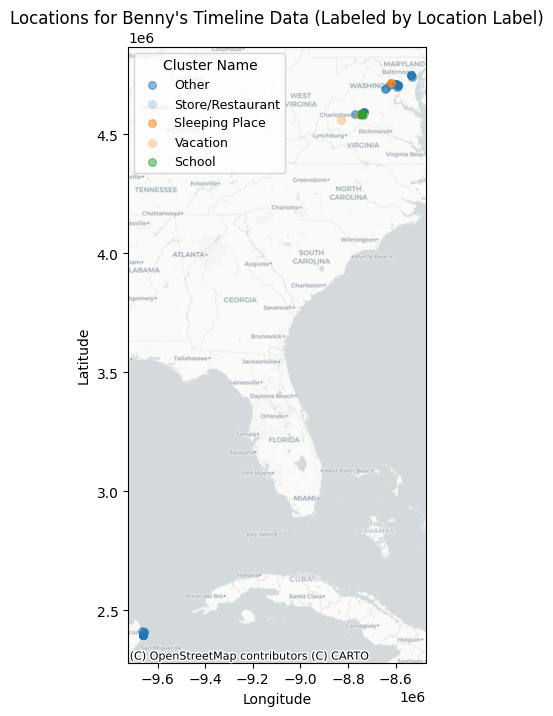

In [ ]:
gdf = gpd.GeoDataFrame(
    filtered_locations,
    geometry=gpd.points_from_xy(filtered_locations.longitude, filtered_locations.latitude)
)

# Set coordinate system to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator projection for better plotting
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 8))

# Create a color map for unique place names
unique_places = gdf["location_label"].unique()
colors = plt.cm.tab20(range(len(unique_places)))  # Generate unique colors

# Plot each place separately
for place, color in zip(unique_places, colors):
    subset = gdf[gdf["location_label"] == place]
    subset.plot(ax=ax, color=color, markersize=30, label=place, alpha=0.5)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Labels and title
ax.set_title("Locations for Benny's Timeline Data (Labeled by Location Label)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add legend inside the plot at the top left
ax.legend(
    title="Cluster Name",
    loc="upper left",
    fontsize=9
)

# Show the plot
plt.show()

In [ ]:
filtered_locations

,start_time,end_time,latitude,longitude,duration,cluster,place_name,place_types,place_vicinity,location_label
0,2024-11-02 21:16:46.048000-04:00,2024-11-03 12:09:33.053000-05:00,38.051446,-78.498845,57167.005,-1,Charlottesville,"['locality', 'political']",Charlottesville,Other
1,2024-11-12 13:09:04.706000-05:00,2024-11-14 16:34:10.590000-05:00,38.008758,-78.500588,185105.884,6,Wegmans Pharmacy,"['pharmacy', 'health', 'store', 'point_of_inte...","100 Wegmans Way, Charlottesville",Store/Restaurant
2,2024-11-23 11:44:48.034000-05:00,2024-11-23 12:28:31.041000-05:00,38.890898,-77.451366,2623.007,-1,Chantilly,"['locality', 'political']",Chantilly,Other
3,2024-11-23 16:29:39.558000-05:00,2024-11-23 16:39:57.033000-05:00,38.949726,-77.408565,617.475,-1,Hunter Mill District,"['neighborhood', 'political']",None,Sleeping Place
4,2024-11-23 16:29:39.558000-05:00,2024-11-23 16:39:57.033000-05:00,38.950304,-77.407720,617.475,-1,Hunter Mill District,"['neighborhood', 'political']",None,Sleeping Place
...,...,...,...,...,...,...,...,...,...,...
95,2025-03-11 12:07:00-04:00,2025-03-11 13:37:00-04:00,38.046713,-78.506920,5400.000,10,University of Virginia,"['locality', 'political']",University of Virginia,School
96,2025-03-12 16:37:00-04:00,2025-03-12 17:18:00-04:00,38.108889,-78.440993,2460.000,-1,Hollymead,"['locality', 'political']",Hollymead,Other
97,2025-03-17 00:19:00-04:00,2025-03-17 00:55:00-04:00,38.046349,-78.506976,2160.000,10,University of Virginia,"['locality', 'political']",University of Virginia,School
98,2025-03-20 14:30:00-04:00,2025-03-20 14:45:00-04:00,38.052202,-78.501357,900.000,9,Charlottesville,"['locality', 'political']",Charlottesville,Other


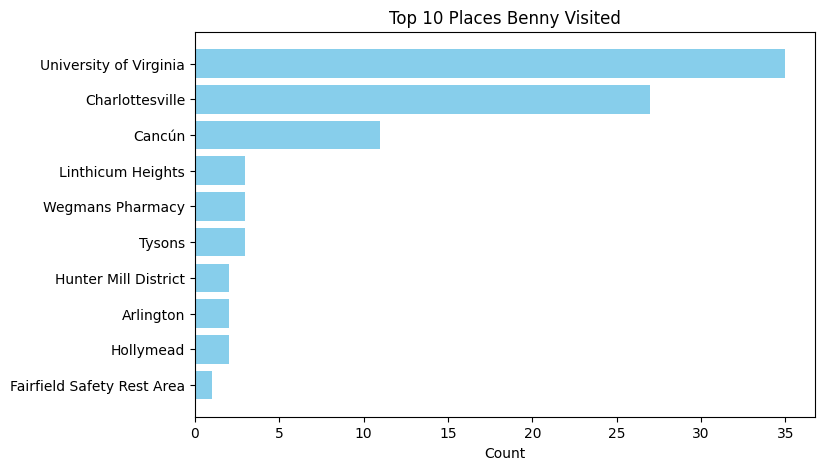

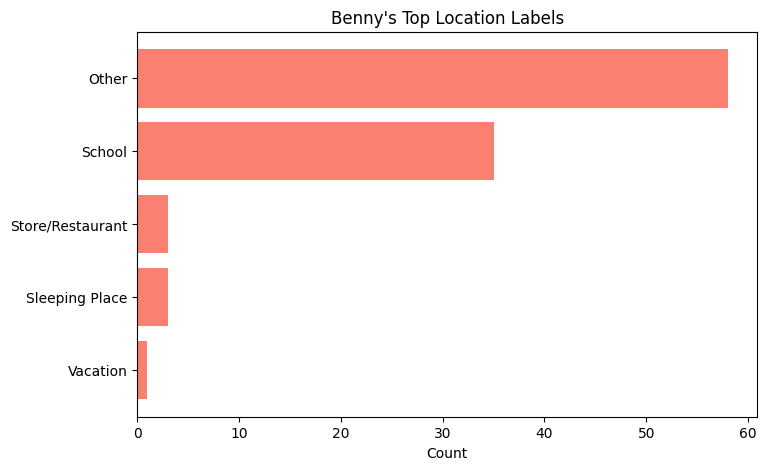

In [ ]:
place_counts = filtered_locations['place_name'].value_counts().nlargest(10)
location_counts = filtered_locations['location_label'].value_counts()

# Plot Top 10 Places Visited
plt.figure(figsize=(8, 5))
plt.barh(place_counts.index, place_counts.values, color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Places Benny Visited')
plt.xlabel('Count')
plt.show()

# Plot Top Location Labels
plt.figure(figsize=(8, 5))
plt.barh(location_counts.index, location_counts.values, color='salmon')
plt.gca().invert_yaxis()
plt.title("Benny's Top Location Labels")
plt.xlabel('Count')
plt.show()

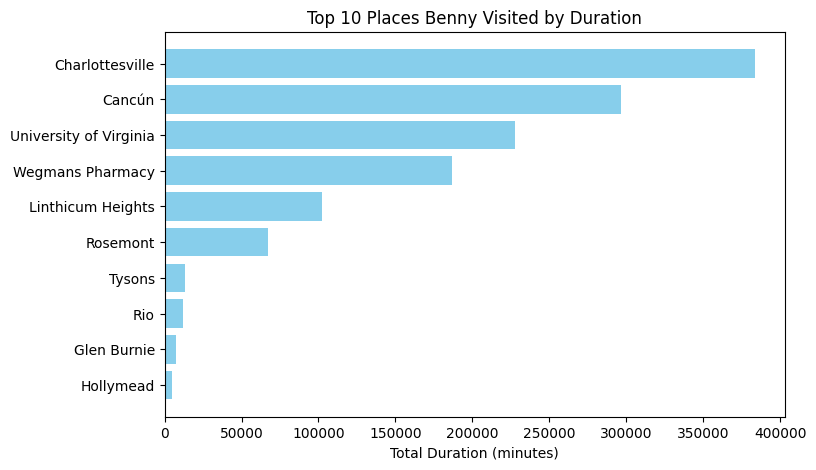

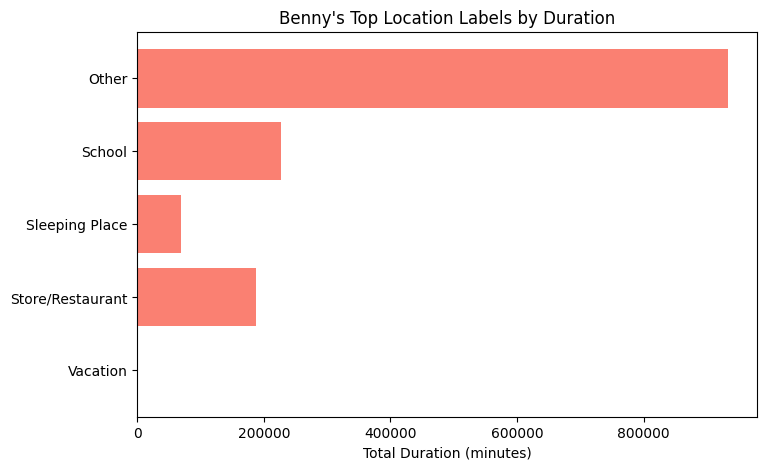

In [ ]:
place_duration = filtered_locations.groupby('place_name')['duration'].sum().nlargest(10)
location_duration = filtered_locations.groupby('location_label')['duration'].sum()

# Plot Top 10 Places by Duration
plt.figure(figsize=(8, 5))
plt.barh(place_duration.index, place_duration.values, color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Places Benny Visited by Duration')
plt.xlabel('Total Duration (minutes)')
plt.show()

# Plot Top Location Labels by Duration
plt.figure(figsize=(8, 5))
plt.barh(location_duration.index, location_duration.values, color='salmon')
plt.gca().invert_yaxis()
plt.title("Benny's Top Location Labels by Duration")
plt.xlabel('Total Duration (minutes)')
plt.show()